In [13]:
import pandas as pd
import numpy as np
import glob
import os
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# CSV 파일 경로 로드
file_paths = sorted(glob.glob('papaya_data/*.csv'))  # 경로 필요시 수정
all_data = []

for file in file_paths:
    df = pd.read_csv(file)

    # ✅ 'Back' 클래스 제거
    if 'Back' in df.iloc[:, -1].unique():
        before = len(df)
        df = df[df.iloc[:, -1] != 'Back']
        after = len(df)
        print(f"{os.path.basename(file)}: 'Back' 제거됨 ({before - after}개)")

    all_data.append(df)

data_all = pd.concat(all_data, axis=0).reset_index(drop=True)
print(f"전체 시점 수 (Back 제거 후): {len(data_all)}")


avg_100ms_Jade_s23_pedLog_1754295834137.csv: 'Back' 제거됨 (209개)
avg_100ms_gracie2_s23_pedLog_1754295826889.csv: 'Back' 제거됨 (57개)
avg_100ms_gracie_s23_pedLog_1754295955777.csv: 'Back' 제거됨 (140개)
전체 시점 수 (Back 제거 후): 10685


In [14]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. 데이터 복사
data_all = data_all.copy()

# 2. azimuth → sin, cos 변환
data_all['azimuth_sin'] = np.sin(np.radians(data_all['azimuth']))
data_all['azimuth_cos'] = np.cos(np.radians(data_all['azimuth']))

# 🔹 방향각의 변화량 (delta azimuth) 추가
azimuth_rad = np.radians(data_all['azimuth'])
delta_azimuth = np.diff(azimuth_rad, prepend=azimuth_rad.iloc[0])
delta_azimuth = (delta_azimuth + np.pi) % (2 * np.pi) - np.pi  # [-π, π] 범위로 정규화
data_all['dAzimuth'] = delta_azimuth

# 3. 가속도 변화량 계산 (1차 차분)
for axis in ['X', 'Y', 'Z']:
    col = f'Accel{axis}'
    dcol = f'dAccel{axis}'
    if col in data_all.columns:
        data_all[dcol] = data_all[col].diff().fillna(0)

# 4. 정규화할 feature 선택
exclude_cols = ['timestamp', 'timestamp_offset', 'direction', 'azimuth']
feature_cols = [col for col in data_all.columns if col not in exclude_cols]

# 5. 정규화 수행
scaler = StandardScaler()
data_all[feature_cols] = scaler.fit_transform(data_all[feature_cols])

# 6. 불필요한 컬럼 제거
cols_to_drop = [col for col in ['timestamp', 'timestamp_offset', 'azimuth'] if col in data_all.columns]
data_all = data_all.drop(columns=cols_to_drop)

# 7. direction을 마지막 열로 이동
data_all = data_all[[col for col in data_all.columns if col != 'direction'] + ['direction']]


In [15]:
from sklearn.preprocessing import LabelEncoder

window_size = 5

# 1. 라벨 인코더 정의
label_encoder = LabelEncoder()

# 2. 라벨 열 추출하여 변환
all_labels = data_all.iloc[:, -1].astype(str)
label_encoder.fit(all_labels)
print("클래스 인코딩 매핑:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# 3. 슬라이딩 윈도우 생성 (✅ 최빈값 라벨 사용)
X_all, y_all = [], []

for i in range(len(data_all) - window_size + 1):
    window = data_all.iloc[i:i+window_size]
    features = window.iloc[:, :-1].values.astype(np.float32)

    # ✅ 최빈값 라벨 사용
    label_mode_str = window.iloc[:, -1].mode()[0]
    label_encoded = label_encoder.transform([label_mode_str])[0]

    X_all.append(features)
    y_all.append(label_encoded)

X_all = np.array(X_all)
y_all = np.array(y_all)

print(f"슬라이딩 윈도우 수: {len(X_all)}")
print(f"입력 형태: {X_all.shape}, 라벨 분포: {np.unique(y_all, return_counts=True)}")


클래스 인코딩 매핑: {'Front': 0, 'Left': 1, 'Right': 2, 'Stay': 3}
슬라이딩 윈도우 수: 10681
입력 형태: (10681, 5, 15), 라벨 분포: (array([0, 1, 2, 3]), array([7704,  867, 1041, 1069], dtype=int64))


In [16]:
n_splits = 5
random_seed = 42
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

folds = list(skf.split(X_all, y_all))


In [17]:
import torch
import torch.nn as nn

class CNN_GRU_Classifier(nn.Module):
    def __init__(self, seq_len=5, feature_dim=13, num_classes=4):
        super().__init__()
        #self.seq_len = seq_len
        #self.feature_dim = feature_dim
        self.conv1 = nn.Conv1d(feature_dim, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(input_size=32, hidden_size=32, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(32 * 2, 32)
        self.fc2 = nn.Linear(32, num_classes)
        # softmax 제거: CrossEntropyLoss가 softmax 포함함

    def forward(self, x):
        #x = x.view(-1, self.seq_len, self.feature_dim).permute(0, 2, 1)  # (batch, feature_dim, seq_len)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, channels)
        _, h_n = self.gru(x)
        h = torch.cat([h_n[0], h_n[1]], dim=1)
        x = self.relu(self.fc1(h))
        return self.fc2(x)  # (batch, num_classes), raw logits



===== Fold 0 =====
Epoch 001 | Train Loss: 0.8442 | Val Loss: 0.6624
Epoch 002 | Train Loss: 0.5595 | Val Loss: 0.4875
Epoch 003 | Train Loss: 0.4385 | Val Loss: 0.4225
Epoch 004 | Train Loss: 0.3791 | Val Loss: 0.3961
Epoch 005 | Train Loss: 0.3564 | Val Loss: 0.3837
Epoch 006 | Train Loss: 0.3356 | Val Loss: 0.3712
Epoch 007 | Train Loss: 0.3212 | Val Loss: 0.3633
Epoch 008 | Train Loss: 0.3023 | Val Loss: 0.3562
Epoch 009 | Train Loss: 0.2924 | Val Loss: 0.3396
Epoch 010 | Train Loss: 0.2767 | Val Loss: 0.3390
Epoch 011 | Train Loss: 0.2657 | Val Loss: 0.3241
Epoch 012 | Train Loss: 0.2548 | Val Loss: 0.3142
Epoch 013 | Train Loss: 0.2474 | Val Loss: 0.3121
Epoch 014 | Train Loss: 0.2309 | Val Loss: 0.2954
Epoch 015 | Train Loss: 0.2265 | Val Loss: 0.2956
Epoch 016 | Train Loss: 0.2242 | Val Loss: 0.3141
Epoch 017 | Train Loss: 0.2085 | Val Loss: 0.2895
Epoch 018 | Train Loss: 0.1876 | Val Loss: 0.2950
Epoch 019 | Train Loss: 0.1977 | Val Loss: 0.2869
Epoch 020 | Train Loss: 0.1808

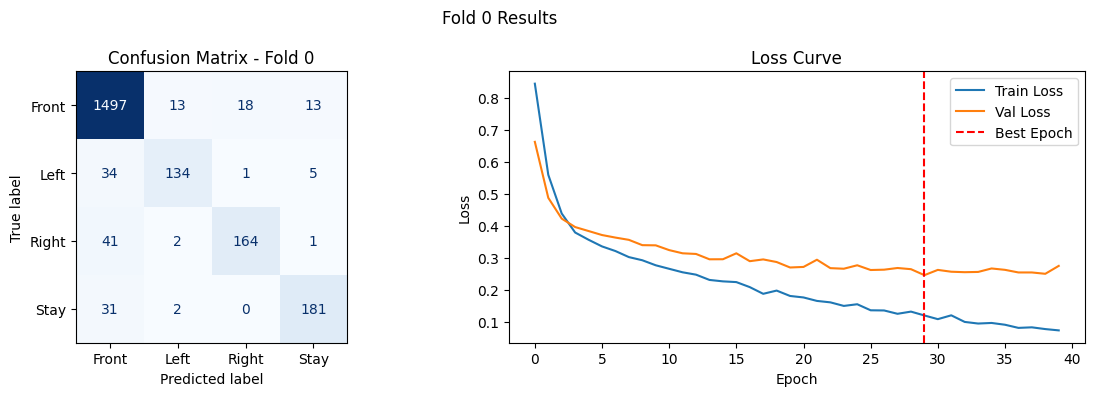


===== Fold 1 =====
Epoch 001 | Train Loss: 0.8608 | Val Loss: 0.6131
Epoch 002 | Train Loss: 0.5961 | Val Loss: 0.5631
Epoch 003 | Train Loss: 0.5155 | Val Loss: 0.4556
Epoch 004 | Train Loss: 0.4192 | Val Loss: 0.3634
Epoch 005 | Train Loss: 0.3694 | Val Loss: 0.3408
Epoch 006 | Train Loss: 0.3508 | Val Loss: 0.3281
Epoch 007 | Train Loss: 0.3335 | Val Loss: 0.3090
Epoch 008 | Train Loss: 0.3164 | Val Loss: 0.3042
Epoch 009 | Train Loss: 0.3057 | Val Loss: 0.2921
Epoch 010 | Train Loss: 0.2885 | Val Loss: 0.3084
Epoch 011 | Train Loss: 0.2817 | Val Loss: 0.2811
Epoch 012 | Train Loss: 0.2647 | Val Loss: 0.2859
Epoch 013 | Train Loss: 0.2615 | Val Loss: 0.2672
Epoch 014 | Train Loss: 0.2388 | Val Loss: 0.2578
Epoch 015 | Train Loss: 0.2311 | Val Loss: 0.2540
Epoch 016 | Train Loss: 0.2272 | Val Loss: 0.2558
Epoch 017 | Train Loss: 0.2097 | Val Loss: 0.2470
Epoch 018 | Train Loss: 0.2044 | Val Loss: 0.2457
Epoch 019 | Train Loss: 0.1965 | Val Loss: 0.2421
Epoch 020 | Train Loss: 0.1840

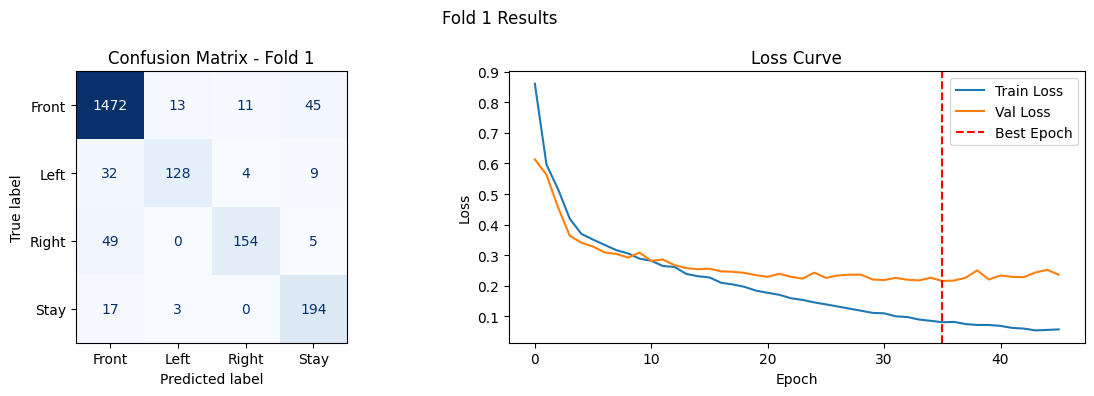


===== Fold 2 =====
Epoch 001 | Train Loss: 0.8550 | Val Loss: 0.5994
Epoch 002 | Train Loss: 0.5980 | Val Loss: 0.5322
Epoch 003 | Train Loss: 0.5169 | Val Loss: 0.4289
Epoch 004 | Train Loss: 0.4247 | Val Loss: 0.3600
Epoch 005 | Train Loss: 0.3817 | Val Loss: 0.3523
Epoch 006 | Train Loss: 0.3643 | Val Loss: 0.3313
Epoch 007 | Train Loss: 0.3431 | Val Loss: 0.3221
Epoch 008 | Train Loss: 0.3335 | Val Loss: 0.2963
Epoch 009 | Train Loss: 0.3078 | Val Loss: 0.2938
Epoch 010 | Train Loss: 0.2991 | Val Loss: 0.3039
Epoch 011 | Train Loss: 0.2885 | Val Loss: 0.2877
Epoch 012 | Train Loss: 0.2744 | Val Loss: 0.2964
Epoch 013 | Train Loss: 0.2606 | Val Loss: 0.2684
Epoch 014 | Train Loss: 0.2461 | Val Loss: 0.2528
Epoch 015 | Train Loss: 0.2501 | Val Loss: 0.2529
Epoch 016 | Train Loss: 0.2321 | Val Loss: 0.2617
Epoch 017 | Train Loss: 0.2221 | Val Loss: 0.2342
Epoch 018 | Train Loss: 0.2119 | Val Loss: 0.2348
Epoch 019 | Train Loss: 0.2084 | Val Loss: 0.2394
Epoch 020 | Train Loss: 0.1928

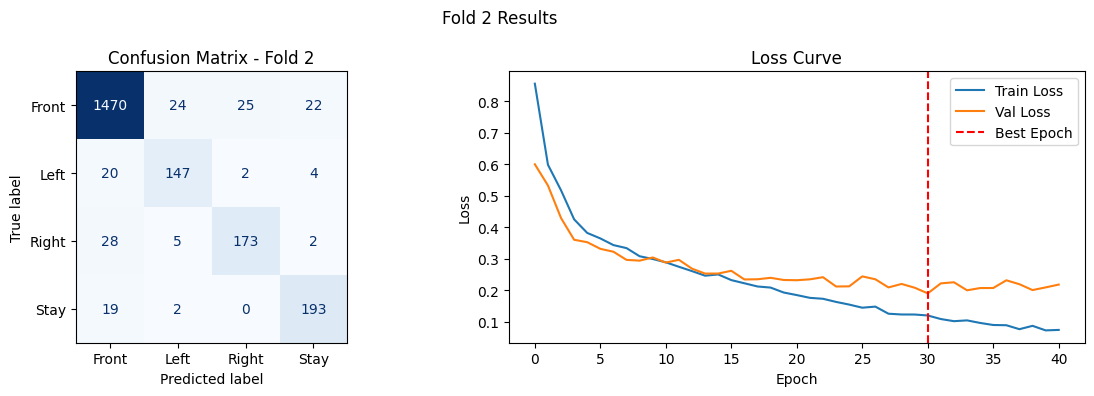


===== Fold 3 =====
Epoch 001 | Train Loss: 0.8291 | Val Loss: 0.5719
Epoch 002 | Train Loss: 0.5553 | Val Loss: 0.4719
Epoch 003 | Train Loss: 0.4461 | Val Loss: 0.3963
Epoch 004 | Train Loss: 0.3918 | Val Loss: 0.3668
Epoch 005 | Train Loss: 0.3658 | Val Loss: 0.3685
Epoch 006 | Train Loss: 0.3458 | Val Loss: 0.3591
Epoch 007 | Train Loss: 0.3253 | Val Loss: 0.3371
Epoch 008 | Train Loss: 0.3132 | Val Loss: 0.3406
Epoch 009 | Train Loss: 0.3050 | Val Loss: 0.3276
Epoch 010 | Train Loss: 0.2863 | Val Loss: 0.3441
Epoch 011 | Train Loss: 0.2801 | Val Loss: 0.3142
Epoch 012 | Train Loss: 0.2692 | Val Loss: 0.3028
Epoch 013 | Train Loss: 0.2501 | Val Loss: 0.3040
Epoch 014 | Train Loss: 0.2464 | Val Loss: 0.2998
Epoch 015 | Train Loss: 0.2315 | Val Loss: 0.2816
Epoch 016 | Train Loss: 0.2213 | Val Loss: 0.2953
Epoch 017 | Train Loss: 0.2217 | Val Loss: 0.2996
Epoch 018 | Train Loss: 0.2077 | Val Loss: 0.2868
Epoch 019 | Train Loss: 0.1978 | Val Loss: 0.2638
Epoch 020 | Train Loss: 0.1829

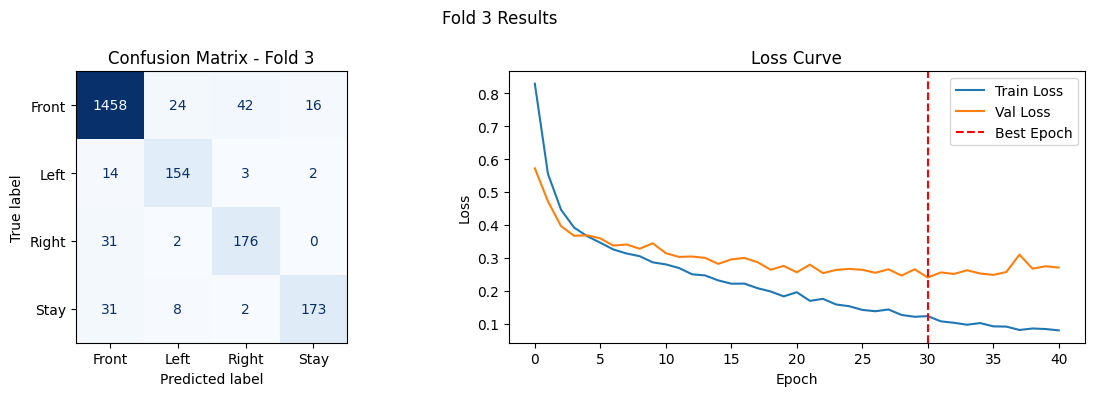


===== Fold 4 =====
Epoch 001 | Train Loss: 0.8361 | Val Loss: 0.6032
Epoch 002 | Train Loss: 0.5761 | Val Loss: 0.5281
Epoch 003 | Train Loss: 0.4900 | Val Loss: 0.4219
Epoch 004 | Train Loss: 0.4118 | Val Loss: 0.3882
Epoch 005 | Train Loss: 0.3683 | Val Loss: 0.3596
Epoch 006 | Train Loss: 0.3492 | Val Loss: 0.3421
Epoch 007 | Train Loss: 0.3312 | Val Loss: 0.3330
Epoch 008 | Train Loss: 0.3124 | Val Loss: 0.3359
Epoch 009 | Train Loss: 0.2937 | Val Loss: 0.3272
Epoch 010 | Train Loss: 0.2906 | Val Loss: 0.3056
Epoch 011 | Train Loss: 0.2840 | Val Loss: 0.2889
Epoch 012 | Train Loss: 0.2601 | Val Loss: 0.2946
Epoch 013 | Train Loss: 0.2558 | Val Loss: 0.2723
Epoch 014 | Train Loss: 0.2422 | Val Loss: 0.2842
Epoch 015 | Train Loss: 0.2346 | Val Loss: 0.2779
Epoch 016 | Train Loss: 0.2183 | Val Loss: 0.2750
Epoch 017 | Train Loss: 0.2099 | Val Loss: 0.2593
Epoch 018 | Train Loss: 0.2084 | Val Loss: 0.2524
Epoch 019 | Train Loss: 0.1931 | Val Loss: 0.2715
Epoch 020 | Train Loss: 0.1860

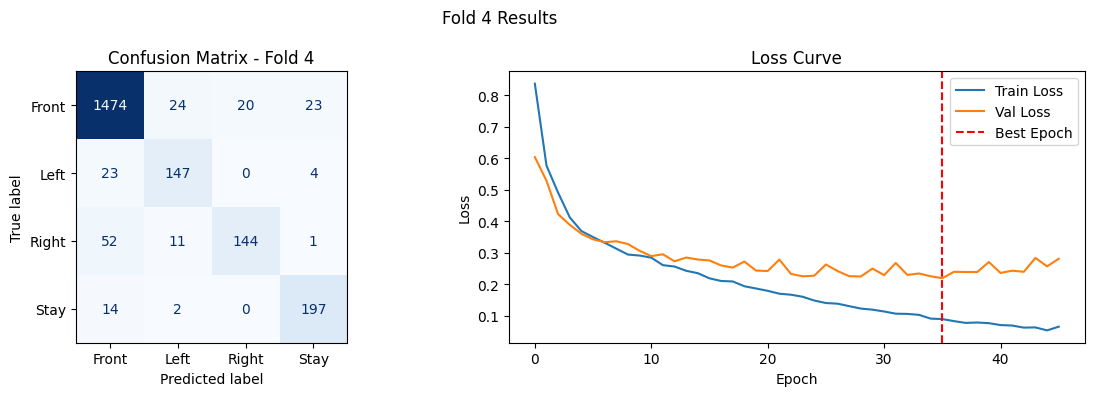


=== Total confusion matrix ===


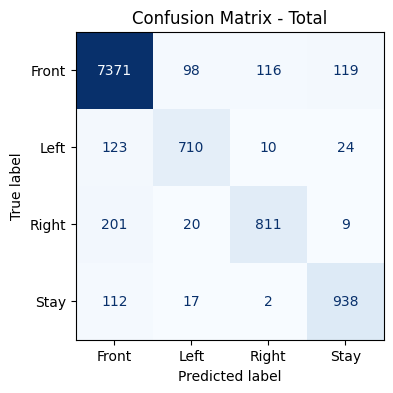

=== Total classification report ===
              precision    recall  f1-score   support

       Front     0.9442    0.9568    0.9504      7704
        Left     0.8402    0.8189    0.8294       867
       Right     0.8637    0.7791    0.8192      1041
        Stay     0.8606    0.8775    0.8689      1069

    accuracy                         0.9203     10681
   macro avg     0.8772    0.8581    0.8670     10681
weighted avg     0.9195    0.9203    0.9197     10681



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# ✅ EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.best_model = None
        self.best_epoch = 0
        self.early_stop = False

    def __call__(self, val_loss, model, epoch):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ✅ 초기 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label_encoder.classes_)
CM_total = np.zeros((num_classes, num_classes), dtype=int)
class_labels = label_encoder.classes_

batch_size = 64
num_epochs = 100
patience = 10

# ✅ 전체 결과 누적 리스트
targets_all = []
preds_all = []

# ✅ K-Fold 학습 루프
for fold_idx, (train_idx, test_idx) in enumerate(folds):
    print(f"\n===== Fold {fold_idx} =====")
    X_trainval, y_trainval = X_all[train_idx], y_all[train_idx]
    X_test, y_test = X_all[test_idx], y_all[test_idx]

    # train/val split
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
    )

    # Tensor 변환
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

    # 모델 초기화
    model = CNN_GRU_Classifier(seq_len=X_train.shape[1], feature_dim=X_train.shape[2], num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=patience)

    train_losses = []
    val_losses = []

    # 학습 루프
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        avg_train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # 검증
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        early_stopping(avg_val_loss, model, epoch)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

    # 최적 모델 로드
    model.load_state_dict(early_stopping.best_model)
    print(f"Best epoch: {early_stopping.best_epoch}")

    # ✅ 테스트셋 평가
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            outputs = model(xb)
            pred_labels = outputs.argmax(dim=1).cpu().numpy()
            preds.extend(pred_labels)
            targets.extend(yb.numpy())

    # ✅ 결과 누적
    preds_all.extend(preds)
    targets_all.extend(targets)

    # ✅ fold별 confusion matrix
    cm = confusion_matrix(targets, preds, labels=range(num_classes))
    CM_total += cm

    print(f"\nFold {fold_idx} 결과")
    print(classification_report(targets, preds, target_names=class_labels, digits=4))

    # ✅ 시각화
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax[0], cmap='Blues', colorbar=False, values_format='d')
    ax[0].set_title(f'Confusion Matrix - Fold {fold_idx}')

    ax[1].plot(train_losses, label='Train Loss')
    ax[1].plot(val_losses, label='Val Loss')
    ax[1].axvline(early_stopping.best_epoch - 1, color='red', linestyle='--', label='Best Epoch')
    ax[1].set_title('Loss Curve')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.suptitle(f'Fold {fold_idx} Results')
    plt.tight_layout()
    plt.show()

# ✅ 전체 confusion matrix 출력
print("\n=== Total confusion matrix ===")
disp_total = ConfusionMatrixDisplay(confusion_matrix=CM_total, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(4, 4))
disp_total.plot(ax=ax, cmap='Blues', colorbar=False, values_format='d')
plt.title("Confusion Matrix - Total")
plt.show()

# ✅ 전체 classification report 출력
print("=== Total classification report ===")
print(classification_report(targets_all, preds_all, target_names=class_labels, digits=4))
